## Notes 

- want to be around the participant's net value = 0 point to see subtle shifts in cost-benefit integration reflected in behaviour

- since net value depends on participant's k, pre-test to find each participants' 70/30, 50/50, and 30/70 approach/avoid thresholds

- same stimuli (except positive vs negative value) for approach and avoid blocks

- for confidence decisions think about sorting by variances and boundary to affect average confidence


### Import stuff

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random

### Define stimulus reward distributions

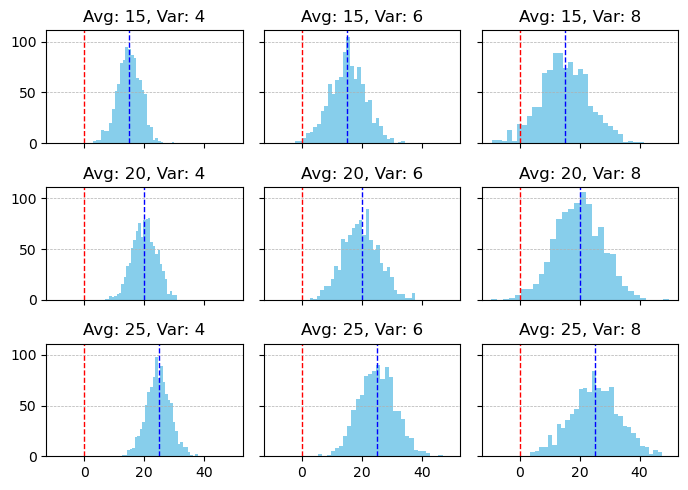

In [34]:
# define 9 stimulus types
reward_means = [15, 20, 25]  # three different means
reward_variances = [4, 6, 8]  # three different variances

stimuli = [(mean, variance) for mean in reward_means for variance in reward_variances]


# visualise reward distributions of the 9 types
def simulate_rewards(avg, var, num_samples=1000):
    return np.random.normal(avg, var, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(7, 5), sharex=True, sharey=True)
for i, (avg, var) in enumerate(stimuli):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    rewards = simulate_rewards(avg, var)
    ax.hist(rewards, bins=30, color='skyblue')
    ax.axvline(avg, color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(0, color='red', linestyle='dashed', linewidth=1)
    ax.set_title(f'Avg: {avg}, Var: {var}')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Define effort levels

In [72]:
# define effort levels
effort_levels = np.linspace(6, 10, num=20)  # 20 different effort levels - range of effort levels will depend on pre-test

### Pre-test individual k value - adaptive staircase to find it more quickly? 

xxx

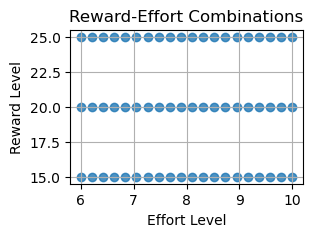

In [36]:
# create reward-effort combinations
reward_effort_combinations = pd.DataFrame([(reward, effort) for reward in reward_means for effort in effort_levels], columns=['Reward', 'Effort Level'])

plt.figure(figsize=(3, 2))
plt.scatter(reward_effort_combinations['Effort Level'], reward_effort_combinations['Reward'], alpha=0.8)
plt.title('Reward-Effort Combinations')
plt.xlabel('Effort Level')
plt.ylabel('Reward Level')
plt.grid(True)
plt.show()

### Pre-test simulations

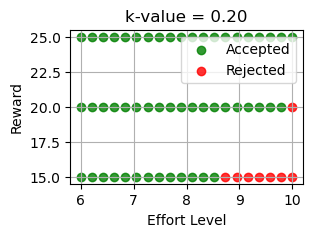

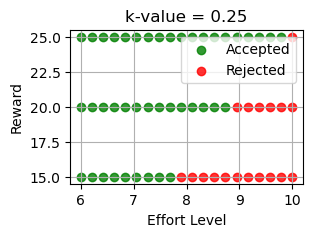

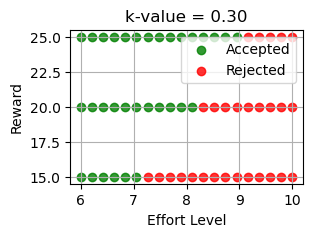

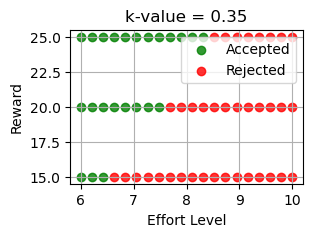

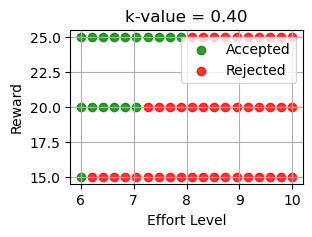

In [71]:
def simulate_responses(data, k):
    """
    Simulate participant responses based on net value calculation.
    Participants accept if the net value is above 0.
    
    :param data: DataFrame with Reward and Effort columns
    :param k: Participant-specific parameter affecting the impact of effort
    :param mean: Average value assigned to rewards
    :param threshold: Net value threshold for acceptance
    """
    # Calculate the net value for each combination
    data['Net Value'] = data['Reward'] - k * data['Effort Level'] ** 2

    # Determine acceptance based on the net value threshold
    data['Accepted'] = data['Net Value'] > 0

    return data


# simulate responses with different k-values
k_values = np.linspace(0.2, 0.4, num=5)

for k in k_values:
    # simulate responses 
    simulated_responses = simulate_responses(reward_effort_combinations.copy(), k=k)


    plt.figure(figsize=(3, 2))
    plt.scatter(simulated_responses[simulated_responses['Accepted']]['Effort Level'], 
                simulated_responses[simulated_responses['Accepted']]['Reward'], 
                color='green', alpha=0.8, label='Accepted')

    plt.scatter(simulated_responses[~simulated_responses['Accepted']]['Effort Level'], 
                simulated_responses[~simulated_responses['Accepted']]['Reward'], 
                color='red', alpha=0.8, label='Rejected')

    plt.title(f'k-value = {k:.2f}')
    plt.xlabel('Effort Level')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
simulated_responses = simulate_responses(reward_effort_combinations.copy(), k=0.3)

In [ ]:


# determine thresholds
def analyze_thresholds(data):
    data_sorted = data.sort_values(by=['Reward', 'Effort'])
    thresholds = {
        '30/70': data_sorted.iloc[int(len(data_sorted) * 0.3)]['Effort'],
        '50/50': data_sorted.iloc[int(len(data_sorted) * 0.5)]['Effort'],
        '70/30': data_sorted.iloc[int(len(data_sorted) * 0.7)]['Effort']
    }
    return thresholds

participant_thresholds = analyze_thresholds(responses)


In [ ]:
import pandas as pd
import numpy as np

# Define rewards and efforts
rewards = np.linspace(1, 100, num=100)  # Example: 100 different reward levels
efforts = np.linspace(1, 100, num=100)  # Example: 100 different effort levels

# Create reward-effort combinations
reward_effort_combinations = pd.DataFrame([(r, e) for r in rewards for e in efforts], columns=['Reward', 'Effort'])

# Function to simulate participant responses (to be replaced with actual experimental data)
def simulate_participant_responses(data):
    # Example logic for simulated responses
    data['Accepted'] = np.random.choice([True, False], size=len(data))
    return data

# Simulate responses for a participant
responses = simulate_participant_responses(reward_effort_combinations)

# Analyze responses to determine thresholds
def analyze_thresholds(data):
    data_sorted = data.sort_values(by=['Reward', 'Effort'])
    thresholds = {
        '30/70': data_sorted.iloc[int(len(data_sorted) * 0.3)]['Effort'],
        '50/50': data_sorted.iloc[int(len(data_sorted) * 0.5)]['Effort'],
        '70/30': data_sorted.iloc[int(len(data_sorted) * 0.7)]['Effort']
    }
    return thresholds

participant_thresholds = analyze_thresholds(responses)


### Create reward - effort combinations

In [4]:
# combine all stimulus types with all effort levels, compute net value, select combinations which are in range

filtered_pairs=[]

# for each stimulus type
for stimulus in stimuli:
    # for each effort level
    for effort in effort_levels:
        # sample a reward from the stimulus' distribution
        mean, variance = stimulus
        reward = np.random.normal(mean, np.sqrt(variance))
        
        # calculate average net value for our range of k_values
        avg_net_value = mean - np.mean(k_values) * effort ** 2
        
        # if the average net value is within the desired range, consider the pair
        if min_threshold <= avg_net_value <= max_threshold:
            filtered_pairs.append((stimulus, reward, effort))
            
            
# for each stimulus type, randomly select 4 (or change that number) reward-effort pairs
schedule = []
for stimulus in stimuli:
    mean, variance = stimulus
    selected_pairs = random.sample([pair for pair in filtered_pairs if pair[0] == stimulus], 4)
    for pair in selected_pairs:
        _, reward, effort = pair
        net_values = {f'net_value_k={k}': mean - k * effort ** 2 for k in k_values}
        schedule.append({
            'stimulus_type': stimulus,
            'actual_reward': reward,
            'effort_required': effort,
            **net_values
        })

In [5]:
# create dataframe
df = pd.DataFrame(schedule)

# randomize the order of trials 
# TO DO: order of trials such that there is some sorting of variances to affec confidence across trials
df = df.sample(frac=1).reset_index(drop=True)

### Plot net value over trials

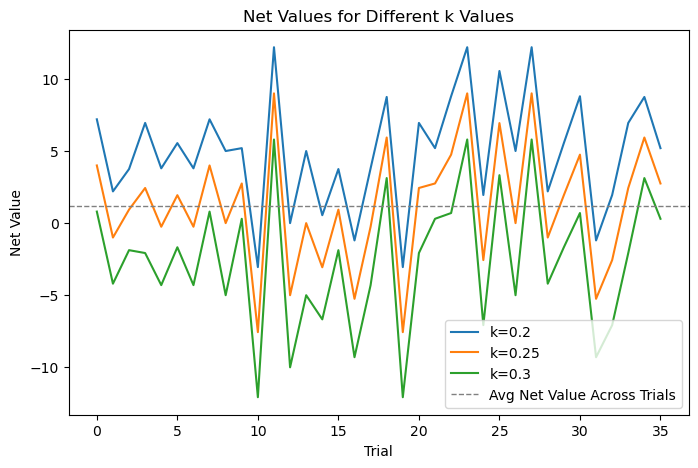

In [6]:
# compute the average net value across all trials and all k values
avg_net_values = [df[f'net_value_k={k}'].mean() for k in k_values]
overall_avg_net_value = sum(avg_net_values) / len(k_values)

# plot net values
plt.figure(figsize=(8, 5))
for k in k_values:
    plt.plot(df.index, df[f'net_value_k={k}'], label=f'k={k}')

plt.axhline(overall_avg_net_value, color='gray', linestyle='--', linewidth=1, label='Avg Net Value Across Trials') # for average k

plt.title('Net Values for Different k Values')
plt.xlabel('Trial')
plt.ylabel('Net Value')
plt.legend()
plt.show()


### Plot reward and effort

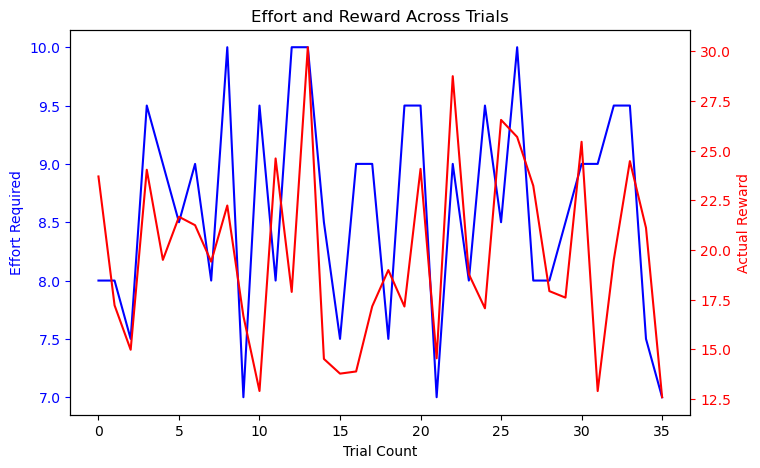

In [7]:
# plot effort and reward over trials
fig, ax1 = plt.figure(figsize=(8, 5)), plt.gca()

# plot effort on the left y-axis
ax1.plot(df.index, df['effort_required'], 'b-', label='Effort Required')
ax1.set_xlabel('Trial Count')
ax1.set_ylabel('Effort Required', color='b')
ax1.tick_params('y', colors='b')

# plot effort on the right y-axis
ax2 = ax1.twinx()
ax2.plot(df.index, df['actual_reward'], 'r-', label='Actual Reward')
ax2.set_ylabel('Actual Reward', color='r')
ax2.tick_params('y', colors='r')

plt.title('Effort and Reward Across Trials')
plt.show()

In [8]:
# calculate the correlation between effort and reward
correlation = df['effort_required'].corr(df['actual_reward'])

print(f"Correlation between effort and reward: {correlation:.2f}")

Correlation between effort and reward: 0.37


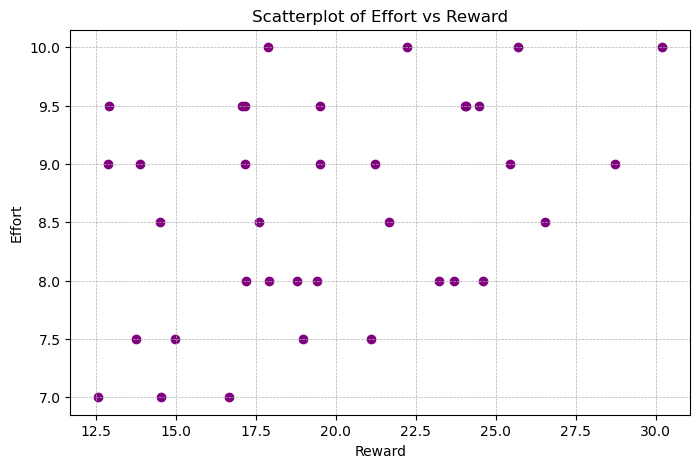

In [9]:
# scatterplot of effort vs. reward to see if we're properly sampling the space
plt.figure(figsize=(8, 5))
plt.scatter(df['actual_reward'], df['effort_required'], color='purple')
plt.title('Scatterplot of Effort vs Reward')
plt.xlabel('Reward')
plt.ylabel('Effort')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Plot how k affects net value - effort relationship

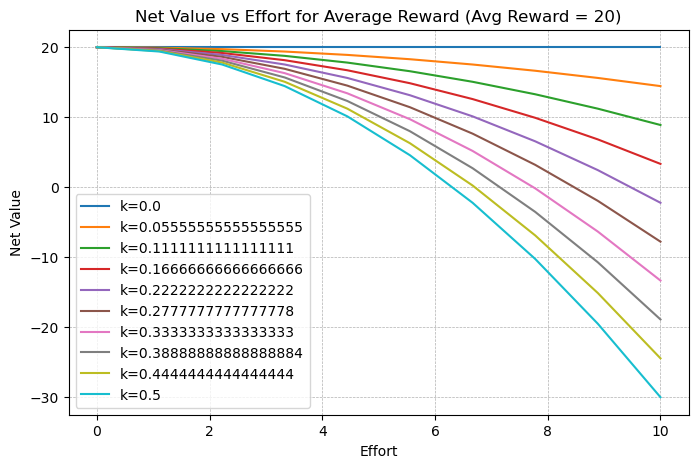

In [10]:
# plot net value versus effort for different k values
plt.figure(figsize=(8, 5))

k_values = np.linspace(0, 0.5, 10)
effort_levels = np.linspace(0, 10, 10)

for k in k_values:
    net_values = []
    for effort in effort_levels:
        # sample an average reward (taking the middle mean for demonstration)
        reward = 20
        net_value = reward - k * effort ** 2
        net_values.append(net_value)
    plt.plot(effort_levels, net_values, label=f'k={k}')


plt.title('Net Value vs Effort for Average Reward (Avg Reward = 20)')
plt.xlabel('Effort')
plt.ylabel('Net Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
